In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Keras modules from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image



In [17]:
img_width, img_height = 256, 256
batchsize = 32

train = image_dataset_from_directory(
    directory='/kaggle/input/anime-char',
    batch_size=batchsize,
    image_size=(img_width, img_height)
)

Found 63565 files belonging to 1 classes.


In [18]:
DIR = '/kaggle/input/anime-char' #path

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size = (64, 64),
        batch_size = batchsize,
        class_mode = None)



Found 63565 images belonging to 1 classes.


In [19]:
from tensorflow.keras.initializers import RandomNormal

initalizer = RandomNormal(mean=0.0, stddev=0.02)
input_dim = 300

def Generator():
    model = Sequential()

    # Random noise input
    model.add(Dense(128 * 16 * 16, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))

    # Upsampling layers
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initalizer))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initalizer))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer for generated image
    model.add(Conv2D(3, (4, 4), padding='same', activation='tanh'))  # Output shape: (64, 64, 3)

    return model

generator = Generator()

In [20]:
def Discriminator(input_shape=(64, 64, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = Discriminator()

In [21]:
from tensorflow.keras import Model

class GAN(Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, real_output)

            fake_images = self.generator(random_noise, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, fake_output)

            d_loss = (d_loss_real + d_loss_fake) / 2

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            fake_images = self.generator(random_noise, training=True)
            fake_output = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {'d_loss': d_loss, 'g_loss': g_loss}

gan = GAN(generator,discriminator,latent_dim=input_dim)


In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

epochs = 15
lr_g = 0.0004
lr_d = 0.0001
beta = 0.6

gan.compile(
    g_optimizer=Adam(learning_rate=lr_g, beta_1=beta),
    d_optimizer=Adam(learning_rate=lr_d, beta_1=beta),
    loss_fn=BinaryCrossentropy()
)

history = gan.fit(train_generator, epochs=epochs)

Epoch 1/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 76s 35ms/step - d_loss: 0.4851 - g_loss: 1.4935
Epoch 2/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - d_loss: 0.3535 - g_loss: 2.2079
Epoch 3/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.2984 - g_loss: 2.4117
Epoch 4/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - d_loss: 0.2915 - g_loss: 2.3665
Epoch 5/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.3418 - g_loss: 1.9921
Epoch 6/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 33ms/step - d_loss: 0.3745 - g_loss: 1.7148
Epoch 7/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - d_loss: 0.4188 - g_loss: 1.5415
Epoch 8/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.3946 - g_loss: 1.6659
Epoch 9/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - d_loss: 0.3636 - g_loss: 1.8566
Epoch 10/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 69s 35ms/step - d_loss: 0.3892 - g_loss: 1.8201
Epoch 11/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 67s 34ms/step - d_loss: 0.3748 - g_loss: 1.8316
Epoch 12

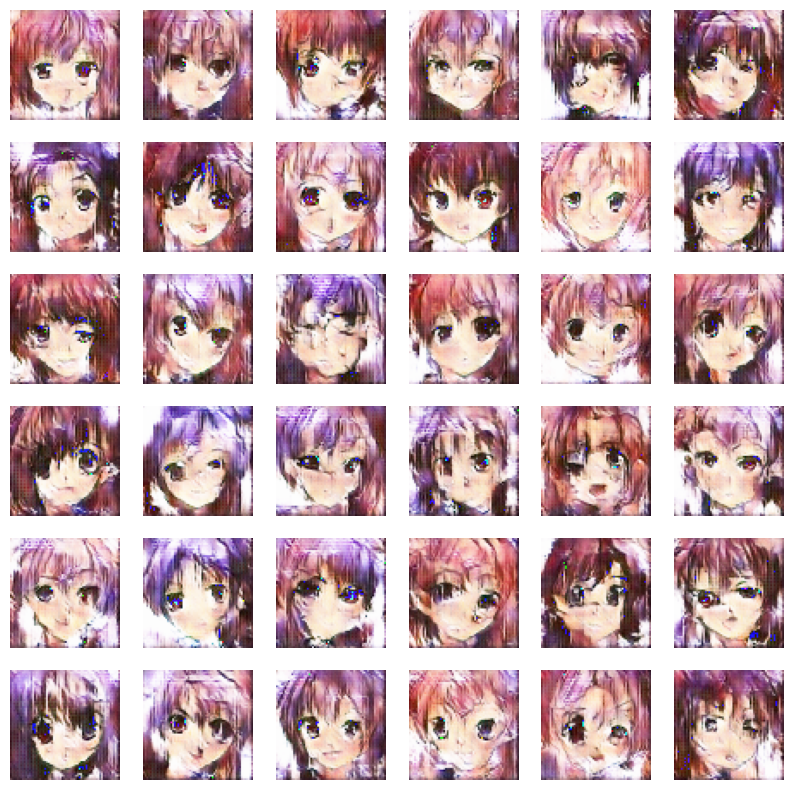

In [23]:
plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    # Generate random noise for each image
    noise = tf.random.normal([1, 300])
    mg = gan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255

    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()
